In [73]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.spatial as sc

In [74]:
image_folder_path = "./fruit-inspection-images"
images_second_task_path = os.path.join(image_folder_path, "second-task")
images_second_task = os.listdir(images_second_task_path)

ir_images = []
color_images = []

for img in images_second_task:
    if img[:2] == "C0":
        ir_images.append(img)
    else:
        color_images.append(img)

def load_image(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_COLOR)
    return image

def load_image_grey(image_number, ir = True):
    ir_image_path = os.path.join(images_second_task_path, ir_images[image_number])
    color_image_path = os.path.join(images_second_task_path, color_images[image_number])
    image = cv2.imread(ir_image_path if ir else color_image_path, cv2.IMREAD_GRAYSCALE)
    return image



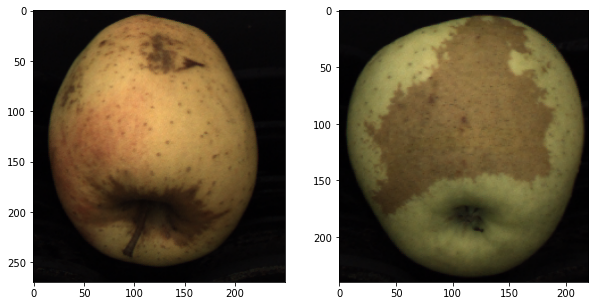

In [75]:
apple1 = load_image(0, False)
apple2 = load_image(1, False)
apple1_color = cv2.cvtColor(apple1, cv2.COLOR_BGR2RGB)
apple2_color = cv2.cvtColor(apple2, cv2.COLOR_BGR2RGB)

apple1_grey = load_image_grey(0, False)
apple2_grey = load_image_grey(1, False)

def show_apples(apple1, apple2):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(apple1)
    plt.subplot(1, 2, 2)
    plt.imshow(apple2)

show_apples(apple1_color, apple2_color)


In [76]:
def create_binary_mask(image_grey):
    ret, th = cv2.threshold(image_grey, 25, 255, cv2.THRESH_BINARY)

    #Floodfill and invert
    th_copy = th.copy()
    h, w = th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(th_copy, mask, (0,0), 255)
    th_inv = cv2.bitwise_not(th_copy)
    im_out = th | th_inv

    #Smoothing the image and removing the borders
    mask = cv2.medianBlur(im_out, 3)
    kernel = np.ones((5, 5), np.uint8) 
    mask = cv2.erode(mask, kernel, iterations = 7)
    return mask

def remove_background(image_grey, image_color):
    #Smoothing the image
    smooth_image = create_binary_mask(image_grey)
    #Get the fruit from the mask
    img_fuit = smooth_image & image_grey

    image_color_copy = image_color.copy()
    for i in range(3):
        image_color_copy[:,:,i] =  smooth_image & image_color_copy[:, :, i]

    return image_color_copy


apple1 = remove_background(apple1_grey, apple1_color)
apple2 = remove_background(apple2_grey, apple2_color)


In order to detect the russet area we apply the Mahalanobis distance between the detected russet color and the pixels in the image. If the value is below a certain threshold, we assume the pixel belongs to the russet area of the apple. 

In order to find a good sample color we took the mean color over all the pixels belonging to the apple only, and neglected the pixels that are all black due to the background having been removed. However, we found that since one of the apples contains more russet-pixels than "normal" apple-pixels, this turned out to "invert" the classification for this apple. So in order to correctly classify russet pixels for that apple, we had to flip the inequality. 

Not very suprsingly, this didn't work out quite well. Using the same technique on both of these apples proved difficult. One of the apples has a more reddish color, and a larger color spectrum. However, after some trial and error, we learned that dividing the mean-color by a factor, thus (in the case of LUV) making the individual colors less meaningful, we obtained better results.


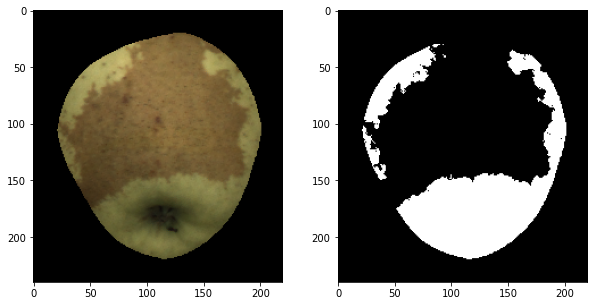

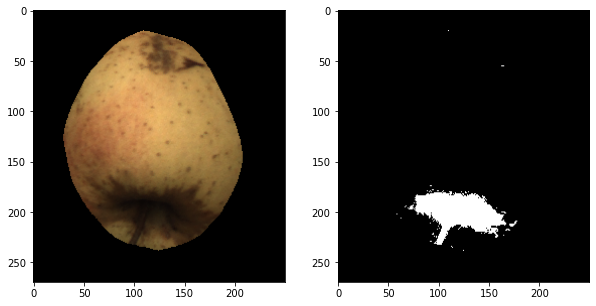

In [77]:
def find_russet(image, binary_mask, threshold):
        image = cv2.medianBlur(image, 3)
        image_LAB = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)

        image_UV = image_LAB[:, :, 1:3]
        image_UV = image_UV.reshape(image_UV.shape[0] * image_UV.shape[1], 2)
        cov, mean = cv2.calcCovarMatrix(image_UV, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
        cov_inv = cv2.invert(cov, cv2.DECOMP_SVD)

        russet = np.zeros((image_LAB.shape[0], image_LAB.shape[1]), dtype="float64")

        #find the true mean
        mask = np.array(binary_mask,dtype=bool)
        mean[0][0] = np.mean(image_LAB[:, :, 1], where = mask)
        mean[0][1] = np.mean(image_LAB[:, :, 1], where = mask)
        russet_sample = mean / image_LAB.shape[0]

        for i in range(image_LAB.shape[0]):
                for j in range(image_LAB.shape[1]):
                        pixel = np.array(image_LAB[i][j])[1:3].reshape(1, 2)
                        if(binary_mask[i][j] != 0): #calculate distance only on apple pixels
                                distance = sc.distance.cdist(pixel, russet_sample, 'mahalanobis', VI=cov_inv[1])
                                if distance < threshold:
                                        russet[i][j] = 255
        return russet

def show_comparison(apple1, russet):
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.imshow(apple1)
    plt.subplot(1, 2, 2)
    plt.imshow(russet, cmap="gray", vmin=0, vmax=255)

#TODO: thresholdene er hardkodet
russet2 = find_russet(apple2, create_binary_mask(apple2_grey), 18)
show_comparison(apple2, russet2)

russet1 = find_russet(apple1, create_binary_mask(apple1_grey), 8.8)
show_comparison(apple1, russet1)

In [79]:
#TODO: jeg har ikke sett på dette enda

def get_pixel_value(im, i, j):
                pixel = np.array( [ im[i,j,0],   im[i,j,1], im[i,j,2] ]) 
                return pixel

def mahalanobis_distance(rgb_image, rgb_mean_vector, covariance_matrix):
        rgb_channels = cv2.split(rgb_image)
        R, G, B = rgb_channels[0], rgb_channels[1], rgb_channels[2]
        R_mean, G_mean, B_mean = rgb_mean_vector[0], rgb_mean_vector[1], rgb_mean_vector[2]
        distance = (((R - R_mean)**2/covariance_matrix[0,0]) + ((G - G_mean)**2/covariance_matrix[1,1]) + ((B - B_mean)**2/covariance_matrix[2,2]))
        return np.sqrt(distance)

def find_russet_rgb(img_fruit_color, smooth_image):
        img_fruit_color = cv2.medianBlur(img_fruit_color, 3)

        rgb_channels = cv2.split(img_fruit_color)
        R = rgb_channels[0]
        G = rgb_channels[1]
        B = rgb_channels[2]

        covDataRGB = [R.flatten(), G.flatten(), B.flatten()]
        covMatrixRGB = np.cov(covDataRGB, bias=True)
        mask = np.array(smooth_image,dtype=bool)

        mean1 = np.mean(R, where = mask)
        mean2 = np.mean(G, where = mask)
        mean3 = np.mean(B, where = mask)
        mean = np.array([mean1,mean2,mean3])
        #mean = np.array([133,107,60])
        mean = mean/ len(img_fruit_color)

        dist = mahalanobis_distance(img_fruit_color, mean, covMatrixRGB)

        print(np.min(dist))
        print(np.max(dist))

        russet = np.zeros((img_fruit_color.shape[0], img_fruit_color.shape[1]), dtype="float64")


        for i in range(dist.shape[0]):
                for j in range(dist.shape[1]):
                        if dist[i][j] < 1.5:
                                russet[i][j] = 255

